## 1. Load data from all sessions

#### Load name and path of all sessions

In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from session_utils import find_all_sessions

# Find all included sessions from Google sheet, with structure session_name: path
session_dict = find_all_sessions(sheet_path = 'https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=0',
                                 data_path = '/home/isabella/Documents/isabella/jake/recording_data',
                                 sorting_suffix = 'sorting_ks2_custom')
print(f'{len(session_dict.items())} sessions found')

57 sessions found


## 2. Loop over all sessions, load data and filter for pyramidal cells
### Criteria:
#### - A. Cluster marked 'good' in phy
#### - B. Cluster depth 0 +-200um
#### - C. Mean FR < 10 Hz
#### - D. Mean spike width >300us
#### - E. Burst index - first moment of AC < 25

In [60]:
from ephys import *
import matplotlib.pyplot as plt


total_cells_inc = 0
total_cells_processed = 0

cluster_info_all = pd.DataFrame()

for session, session_path in session_dict.items():
    
    # Create ephys object
    obj = ephys(recording_type = 'nexus', path = session_path)
    
    ## A. Load good cells from phy
    obj.load_spikes('good')
    
    # Get cluster info from phy
    cluster_info = obj.spike_data['cluster_info']

    cluster_info['session'] = session
    
    # Get total good cells for session
    total_cells = len(cluster_info.index)
    total_cells_processed += total_cells
    
    
    ## B. Get cluster depths and exclude any outside of 0 +-200um
    cluster_info = cluster_info[cluster_info['depth'].between(-200, 200)].copy()
    

    ## C. Filter for mean firing rate between 0-10 Hz
    cluster_info = cluster_info[cluster_info['fr'].between(0, 10)]
    
    ## D. Filter for spike width >300 us from template
    if not cluster_info.empty:
        obj.load_mean_waveforms(clusters_to_load = list(cluster_info.index)) #Pick up to 500 spikes at random for performance

        # Calculate spike width for each cluster from mean of every 50th spike 
        for cluster, mean_waveform in obj.mean_waveforms.items():
            
            # Find peak to trough time in us
            peak = np.argmin(mean_waveform)
            trough = np.argmax(mean_waveform[peak:]) + peak
            peak_to_trough = trough - peak         

            # # Plot for sanity
            # print(f'Spike width for cluster {cluster}: {peak_to_trough / obj.spike_data["sampling_rate"] * 1e6} us')
            # plt.plot(mean_waveform)
            # plt.scatter(trough, mean_waveform[trough])
            # plt.scatter(peak, mean_waveform[peak])
            # plt.show()

            cluster_info.loc[cluster, 'spike_width_microseconds'] = (peak_to_trough / obj.spike_data['sampling_rate']) * 1e6
        
        # Filter for spike width > 300us as in Wills et al., 2010
        cluster_info = cluster_info[cluster_info['spike_width_microseconds'] > 500].copy()

    
    ## E. Calculate burst index and filter
    if not cluster_info.empty:
        
        # Reload spike data only for included cells
        clusters_inc = list(cluster_info.index)
        obj.load_spikes(clusters_to_load = clusters_inc)
        
        # Generate autocorrelograms and burst index for each cluster
        from burst_index_and_autocorrelograms import *

        spike_times_inc = obj.spike_data['spike_times']
        spike_clusters_inc = obj.spike_data['spike_clusters']

        autocorrelograms, first_moments = compute_autocorrelograms_and_first_moment(spike_times_inc, 
                                                                                     spike_clusters_inc, 
                                                                                     bin_size = 0.001, #1ms
                                                                                     time_window = 0.05) #50ms
        
        cluster_info['first_moment_AC'] = first_moments.values()
        
        # Filter for first moment <25
        cluster_info = cluster_info[cluster_info['first_moment_AC'] < 25]
            
    ## SAVE INCLUDED CLUSTER IDs TO .NPY
    clusters_inc = cluster_info.index
    n_clusters_inc = len(cluster_info.index)
    total_cells_inc += n_clusters_inc

    # Append session to cluster_info_all index
    cluster_info.index = cluster_info['session'] + '_' + cluster_info.index.astype(str)
    
    # Concat cluster info for all sessions
    cluster_info_all = pd.concat([cluster_info_all, cluster_info])

    np.save(f'{session_path}/clusters_inc.npy', clusters_inc)        
        
    print(f'Session {session}: {n_clusters_inc} cells retained of {total_cells} good cells from phy. Retained cells: {clusters_inc.values}')

print(f'Total cells retained: {total_cells_inc} of total {total_cells_processed} good cells from phy')

Session 230503_r1354: 0 cells retained of 5 good cells from phy. Retained cells: []
Session 230504_r1354: 0 cells retained of 8 good cells from phy. Retained cells: []
Session 230505_r1354: 0 cells retained of 4 good cells from phy. Retained cells: []
Session 230506_r1354: 10 cells retained of 23 good cells from phy. Retained cells: [247 251 256 260 274 281 292 300 308 322]
Session 230507_r1354: 9 cells retained of 17 good cells from phy. Retained cells: [ 37 205 215 248 253 371 380 388 389]
Session 230508_r1354: 7 cells retained of 15 good cells from phy. Retained cells: [326 343 350 356 363 374 390]
Session 230509_r1354: 9 cells retained of 22 good cells from phy. Retained cells: [233 301 307 359 362 363 364 366 367]
Session 230510_r1354: 6 cells retained of 15 good cells from phy. Retained cells: [249 267 286 300 303 337]
Session 230607_r1364: 23 cells retained of 41 good cells from phy. Retained cells: [134 233 237 240 250 284 321 344 348 362 378 412 421 425 426 428 430 431
 432 43

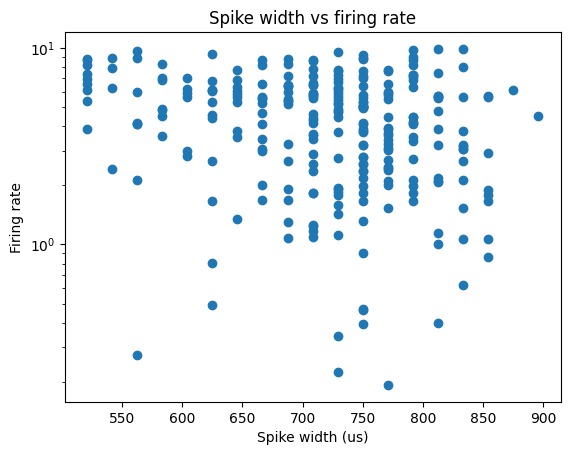

In [61]:
plt.scatter(cluster_info_all['spike_width_microseconds'], cluster_info_all['fr'])
plt.xlabel('Spike width (us)')
# Set y axis to log 10 scale
plt.yscale('log')
plt.ylabel('Firing rate')
plt.title('Spike width vs firing rate')
plt.show()

In [62]:
# Load spatial info all
spatial_info_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/spatial_info_all.pkl')

# Select only rows including 'open-field_1'
spatial_info_open_field_1 = spatial_info_all[spatial_info_all.index.str.contains('raw_open-field_1')]

# Drop 'open-field_1' from index
spatial_info_open_field_1.index = spatial_info_open_field_1.index.str.replace('raw_open-field_1_', '')


spatial_info_open_field_1

,bits_per_spike,bits_per_sec,age
230504_r1354_248,0.140865,0.311954,24
230506_r1354_191,0.012147,0.371689,26
230506_r1354_203,0.012131,0.125972,26
230506_r1354_214,0.01688,0.16295,26
230506_r1354_236,0.014669,0.128275,26
...,...,...,...
231101_r1428_283,0.021809,0.206171,34
231101_r1428_285,0.053854,0.352384,34
231101_r1428_301,0.070981,0.308645,34
231101_r1428_309,0.028625,0.092814,34


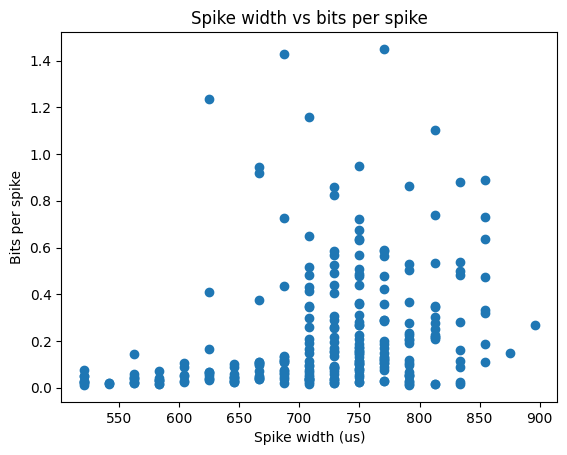

In [63]:
# Merge cluster_info_all with spatial_info_open_field_1
cluster_info_spatial_info = pd.merge(cluster_info_all, spatial_info_open_field_1, left_index = True, right_index = True)

# Plot spike width against bits per spike
plt.scatter(cluster_info_spatial_info['spike_width_microseconds'], cluster_info_spatial_info['bits_per_spike'])
plt.xlabel('Spike width (us)')
plt.ylabel('Bits per spike')
plt.title('Spike width vs bits per spike')
plt.show()

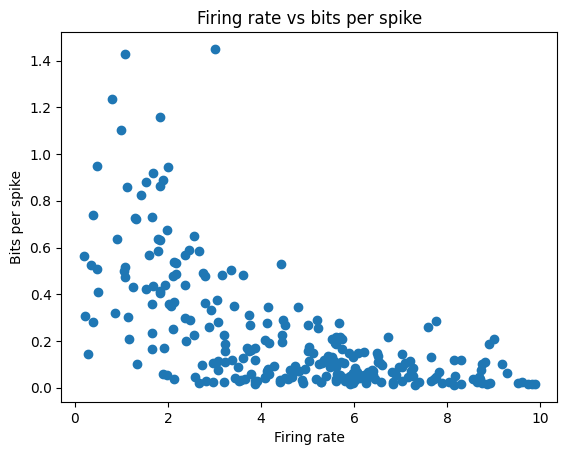

In [64]:
# Plot firing rate against bits per spike
plt.scatter(cluster_info_spatial_info['fr'], cluster_info_spatial_info['bits_per_spike'])
plt.xlabel('Firing rate')
plt.ylabel('Bits per spike')
plt.title('Firing rate vs bits per spike')
plt.show()

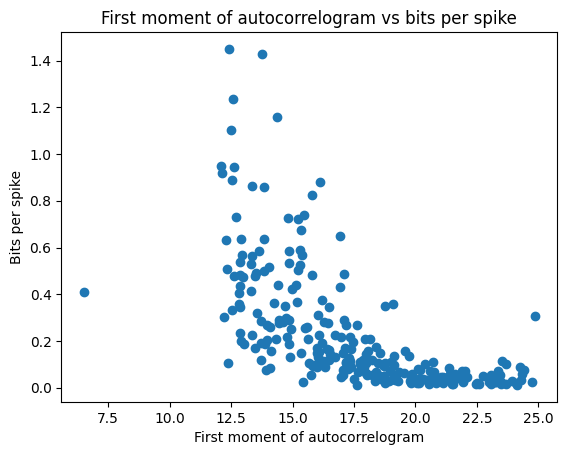

In [65]:
# Plot first moment of autocorrelogram against bits per spike
plt.scatter(cluster_info_spatial_info['first_moment_AC'], cluster_info_spatial_info['bits_per_spike'])
plt.xlabel('First moment of autocorrelogram')
plt.ylabel('Bits per spike')
plt.title('First moment of autocorrelogram vs bits per spike')
plt.show()

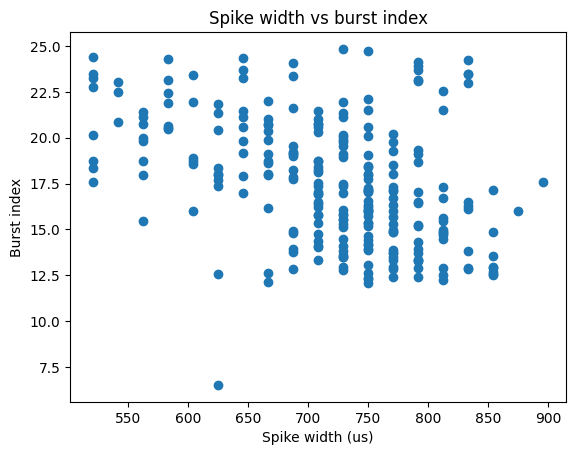

In [66]:
# Plot spike width vs burst index
plt.scatter(cluster_info_spatial_info['spike_width_microseconds'], cluster_info_spatial_info['first_moment_AC'])
plt.xlabel('Spike width (us)')
plt.ylabel('Burst index')
plt.title('Spike width vs burst index')
plt.show()